# Load data

In [10]:
# We use as few libraries as possible to make the code more portable, and to make it easier to understand.
# I.e., there are fewer libraries to learn.

import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# A few convenience functions for manipulating data and plotting

# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, z_start, z_target):
        self.z_start = z_start
        self.z_target = z_target
    def __len__(self):
        return len(self.z_start)
    def __getitem__(self, idx):
        return self.z_start[idx], self.z_target[idx]
    
def my_plot(start, end, target, plot_points = 10):
    plt.figure()

    plt.scatter(start[:plot_points,0], start[:plot_points,1])
    plt.scatter(end[:plot_points,0], end[:plot_points,1])
    dx = end[:plot_points,0]-start[:plot_points,0]
    dy = end[:plot_points,1]-start[:plot_points,1]
    plt.quiver(start[:plot_points,0], start[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

    plt.scatter(target[:,0], target[:,1], s=1)
    plt.gca().set_aspect('equal')
    plt.show()

In [15]:
# Select the problem of interest here.  There are the problems for which this notebook is set up, namely the simple 1D input and 1D output problems.

name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'

# Read the start data
z_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
z_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')


# Dynamical system

Here we have our dynamical system/neural network.  This is a simple dense network that attempts to map the start data to the target data.  I.e., it trys to learn the dynamics of the system.

Note, the same network structure is used for all the problems, but the weights will be trained for each problem.

In [16]:
z_size = z_start.shape[1]
# This value is chosen to work well for the problems we consider here, but can definitely be changed.
# Experimenting with this value is a good idea, and a great place to start when trying to improve the performance of the model.
hidden_size = 20
map = torch.nn.Sequential(torch.nn.Linear(z_size, hidden_size),
                          torch.nn.ReLU(), 
                          torch.nn.Linear(hidden_size, hidden_size), 
                          torch.nn.ReLU(), 
                          torch.nn.Linear(hidden_size, z_size))

In [17]:


# Make two pytorch tensor datasets from the start and target data
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)
    
train_data = Data(z_start_tensor, z_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [18]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [19]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = map(start)
        loss = criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 0.3626035749912262
Epoch 100, Batch 9, Loss 6.548148667206988e-05
Epoch 200, Batch 9, Loss 8.100798368104734e-06
Epoch 300, Batch 9, Loss 4.021624590677675e-06
Epoch 400, Batch 9, Loss 9.466918271527902e-08


# Training data

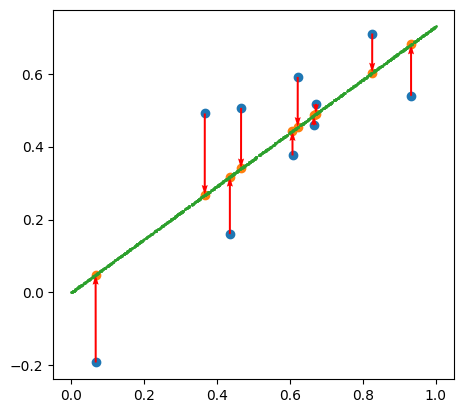

In [20]:
mapped_tensor = map(z_start_tensor).detach()
my_plot(z_start_tensor, mapped_tensor, z_target_tensor)

# Testing data

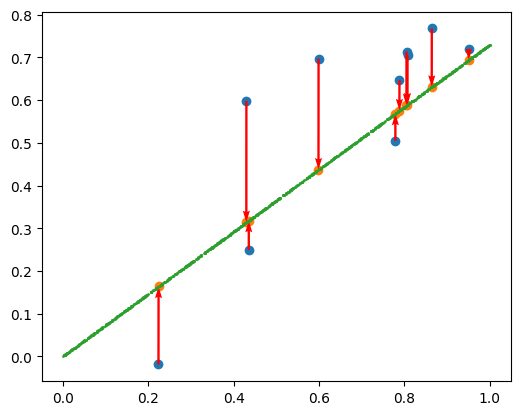

In [22]:
z_start_tensor_test = z_start_tensor+torch.rand_like(z_start_tensor)*0.2
mapped_tensor = map(z_start_tensor_test).detach()
my_plot(z_start_tensor_test, mapped_tensor, z_target_tensor)